In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from keras.layers import Activation


from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from keras.layers import Dropout
import collections
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.model_selection import KFold
from keras.layers import RepeatVector 
from keras.layers import TimeDistributed
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# bootstrapping 
def bootstrap(dataset, sample_size):
    
    sample_size = int(len(train)*0.8)
    boot = resample(train, replace=True, n_samples=sample_size, random_state=2)
    
    return boot

# prepare the data for regression
def create_dataset(data):
    dataX, dataY = [],[]
    for i in range(len(data)):
        dataX.append(data[i][:-1])
        dataY.append([data[i][-1]])
        
    return np.array(dataX), np.array(dataY)

# prepare the data for time-series prediction
def create_3d_dataset(dataset, n_input, n_out=1):
    # flatten data
    data = dataset[:,-1]
    X,Y = [],[]
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end]
            x_input = x_input.reshape((len(x_input),1))
            X.append(x_input)
            Y.append(data[in_end:out_end])
        in_start += 1
        
    return np.array(X), np.array(Y)

# Mean Absolute Percentage Error
def mean_absolute_percentage_error(data_true, data_predict):
    error = 0
    count = 0
    data_true_de = sum(data_true)/len(data_true)
    
    for i in range(len(data_true)):
        error += np.abs((data_true[i]-data_predict[i])/data_true_de)

    return((error/len(data_true))*100)

def add_noise(trainX, trainY):

    trainX = [trainX[i]+np.random.normal(0,0.0001) for i in range(len(trainX))]
    trainY = [trainY[j]+np.random.normal(0,0.0001) for j in range(len(trainY))]
    
    return np.array(trainX), np.array(trainY)   

In [460]:
def random_forest(X,Y):
    
    cvscores = []
    k_fold = KFold(n_splits=2, shuffle=True, random_state=0)
        
    for train_index, test_index in k_fold.split(X, Y):
        
        X_train, y_train = add_noise(X[train_index], Y[train_index])
        
        X_test = X[test_index]
        y_test = Y[test_index]        
        
        rf_model = RandomForestRegressor(n_estimators=10,max_depth=10, random_state=0).fit(X_train, y_train)
        rf_prediction = rf_model.predict(X_test)
        score = mean_absolute_percentage_error(y_test, rf_prediction)
        cvscores.append(score)
        
    return np.mean(cvscores)

def k_nearest_neighbor(X,Y):
    
    cvscores = []
    k_fold = KFold(n_splits=4, shuffle=True, random_state=0)
        
    for train_index, test_index in k_fold.split(X, Y):
        
        X_train, y_train = add_noise(X[train_index], Y[train_index])
        
        X_test = X[test_index]
        y_test = Y[test_index]        
        
        knn_model = KNeighborsRegressor().fit(X_train, y_train)
        knn_prediction = knn_model.predict(X_test)
        score = mean_absolute_percentage_error(y_test, knn_prediction)
        cvscores.append(score)
        
    return np.mean(cvscores)


def decision_tree(X,Y):
    
    cvscores = []
    k_fold = KFold(n_splits=4, shuffle=True, random_state=0)
        
    for train_index, test_index in k_fold.split(X, Y):
        
        X_train, y_train = add_noise(X[train_index], Y[train_index])
        
        X_test = X[test_index]
        y_test = Y[test_index]        
        
        dt_model = DecisionTreeRegressor().fit(X_train, y_train)
        dt_prediction = dt_model.predict(X_test)
        score = mean_absolute_percentage_error(y_test, dt_prediction)
        cvscores.append(score)
        
    return np.mean(cvscores)

def linear_regression(X,Y):
    
    cvscores = []
    k_fold = KFold(n_splits=4, shuffle=True, random_state=0)
        
    for train_index, test_index in k_fold.split(X, Y):
        
        X_train, y_train = add_noise(X[train_index], Y[train_index])
        
        X_test = X[test_index]
        y_test = Y[test_index]        
        
        lr_model = LinearRegression().fit(X_train, y_train)
        lr_prediction = lr_model.predict(X_test)
        score = mean_absolute_percentage_error(y_test, lr_prediction)
        cvscores.append(score)
        
    return np.mean(cvscores)

def svr(X,Y):
    
    cvscores = []
    k_fold = KFold(n_splits=4, shuffle=True, random_state=0)
        
    for train_index, test_index in k_fold.split(X, Y):
        
        X_train, y_train = add_noise(X[train_index], Y[train_index])
        
        X_test = X[test_index]
        y_test = Y[test_index]        
        
        svr_model = SVR(kernel='rbf', degree=3, gamma='scale').fit(X_train, y_train)
        svr_prediction = svr_model.predict(X_test)
        score = mean_absolute_percentage_error(y_test, svr_prediction)
        cvscores.append(score)
        
    return np.mean(cvscores)


def mlp(X,Y):
    cvscores = []
    k_fold = KFold(n_splits=4, shuffle=True, random_state=0)
    verbose, epochs, batch_size = 0, 100, 16
    
    for train_index, test_index in k_fold.split(X,Y):
        X_train, y_train = X[train_index],Y[train_index]
        
        X_test = X[test_index]
        y_test = Y[test_index]
        
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], kernel_initializer='he_uniform'))
        model.add(Activation('relu'))
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(Dense(1))
        model.add(Activation('linear'))
        model.compile(loss = 'mean_absolute_error', optimizer='adam')
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test),
              verbose=verbose)
    
        prediction = model.predict(X_test)
        score = mean_absolute_percentage_error(y_test, prediction)
        cvscores.append(score)
        
    return np.mean(cvscores)

In [4]:
def clean_vs_raw():
    clean_file = "hour_data.csv"
    raw_file = "hour_data_raw.csv"
    
    x_axis = ['MLP-C','MLP-R','RF-C','RF-R','KNN-C','KNN-R','LR-C','LR-R','DT-C','DT-R','SVR-C','SVR-R']
    
    results = {name:[] for name in x_axis}
    
    clean_dataset = pd.read_csv(clean_file).drop(['date_time'], axis=1)
    raw_dataset = pd.read_csv(raw_file).drop(['date_time'], axis=1)
    
    for i in clean_dataset.columns:
        
        # prepare data
        clean_X = dataset.loc[:, clean_dataset.columns!=i].values
        clean_Y = dataset.loc[:, clean_dataset.columns==i].values
        
        raw_X = dataset.loc[:, raw_dataset.columns!=i].values
        raw_Y = dataset.loc[:, raw_dataset.columns==i].values
        
        # normalize the data
        scaler = MinMaxScaler(feature_range=(0,1))
        clean_X = np.array(scaler.fit_transform(clean_X))
        clean_Y = np.array(scaler.fit_transform(clean_Y))
        
        raw_X = np.array(scaler.fit_transform(raw_X))
        raw_Y = np.array(scaler.fit_transform(raw_Y))
        
        results["RF-C"].append(random_forest(clean_X, clean_Y))
        results["DT-C"].append(decision_tree(clean_X, clean_Y))
        results["KNN-C"].append(k_nearest_neighbor(clean_X, clean_Y))
        results["SVR-C"].append(svr(clean_X, clean_Y))
        results["LR-C"].append(linear_regression(clean_X, clean_Y))
        results["MLP-C"].append(mlp(clean_X, clean_Y))
        
        results["RF-R"].append(random_forest(raw_X, raw_Y))
        results["DT-R"].append(decision_tree(raw_X, raw_Y))
        results["KNN-R"].append(k_nearest_neighbor(raw_X, raw_Y))
        results["SVR-R"].append(svr(raw_X, raw_Y))
        results["LR-R"].append(linear_regression(raw_X, raw_Y))
        results["MLP-R"].append(mlp(raw_X, raw_Y))
      
    # make the plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1,1,1)
    
    title_name = "Model Performance"
    box = plt.boxplot(results,patch_artist=True)
    
    colors = ['green', 'blue', 'green', 'blue', 'green', 'blue','green', 'blue','green', 'blue','green', 'blue']
 
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)


    ax.set_title(title_name,fontsize=16)
    ax.xaxis.set_ticklabels(x_axis)
    ax.set_xlabel('Regression Models',fontsize=14)
    ax.set_ylabel('MAPE(%)',fontsize=14)


    green_patch = mpatches.Patch(color='green', label='C - Clean Data')
    blue_patch = mpatches.Patch(color='blue', label='R - Raw Data')
    plt.legend(handles=[green_patch, blue_patch])

#     plt.savefig(title_name+'.jpg', format='jpg', dpi=1000, bbox_inches='tight')
        
    return results

def data_size_plot(save=False):
    
    files = ["eight_size.csv","six_size.csv", "four_size.csv","two_size.csv", "one_size.csv"]    
    
    results = []
    
    for i, file in enumerate(files):
        
        dataset = pd.read_csv(file).drop(['date_time'], axis=1)
        result = []
        
        for col in dataset.columns:
        
            # prepare data
            X = dataset.loc[:, dataset.columns!=col].values
            Y = dataset.loc[:, dataset.columns==col].values
        
            # normalize the data
            scaler = MinMaxScaler(feature_range=(0,1))
            X = np.array(scaler.fit_transform(X))
            Y = np.array(scaler.fit_transform(Y))
        
            result.append(random_forest(X, Y))
        results.append(result)
        
    # make the plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1,1,1)
    
    title_name = "Model Performance"
    box = plt.boxplot(results,patch_artist=False, showmeans=True)
    
    ax.set_title(title_name,fontsize=16)
    ax.xaxis.set_ticklabels(["2 Years", "1.5 Years", "1 Year", "0.5 Year", "1 Month"])
    ax.set_xlabel('Data Size',fontsize=14)
    ax.set_ylabel('MAPE(%)',fontsize=14)
    
    if save is True:
        plt.savefig('data_size_performance.jpg', format='jpg', dpi=1000, bbox_inches='tight')
        
    return

def granularity_plot():
    files = ["cleaned_data.csv","fifteen_data.csv","half_hour_data.csv", "forty_five_min_data.csv","sixty_min_data.csv"] 
    results = []
    
    for i, file in enumerate(files):
            
        dataset = pd.read_csv("granularity_"+file).drop(['date_time'], axis=1)
        result = []
        
        for col in dataset.columns:
            
            # prepare data
            X = dataset.loc[:, dataset.columns!=col].values
            Y = dataset.loc[:, dataset.columns==col].values
        
            # normalize the data
            scaler = MinMaxScaler(feature_range=(0,1))
            X = np.array(scaler.fit_transform(X))
            Y = np.array(scaler.fit_transform(Y))
        
            result.append(random_forest(X, Y))
        results.append(result)
        
    # make the plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1,1,1)
    
    title_name = "Model Performance"
    box = plt.boxplot(results,patch_artist=False, showmeans=True)
    
    ax.set_title(title_name,fontsize=16)
    ax.xaxis.set_ticklabels(["5 Mins", "15 Mins", "30 Mins", "45 Mins", "60 Mins"])
    ax.set_xlabel('Granularity',fontsize=14)
    ax.set_ylabel('MAPE(%)',fontsize=14)

#     plt.savefig('data_granularity_performance.jpg', format='jpg', dpi=1000, bbox_inches='tight')
        
    return

def num_panels():
    
    dataset = pd.read_csv("cleaned_data.csv").drop(['date_time'], axis=1)
    
    cols = dataset.columns
    train = [cols[0]]
    
    
    results = []
    for i in range(1, len(cols)):
        train.append(cols[i])
            
        result = []
        for col in train:
            
            # prepare data
            X = dataset.loc[:, dataset.columns!=col].values
            Y = dataset.loc[:, dataset.columns==col].values
        
            # normalize the data
            scaler = MinMaxScaler(feature_range=(0,1))
            X = np.array(scaler.fit_transform(X))
            Y = np.array(scaler.fit_transform(Y))
            result.append(random_forest(X, Y))
        results.append(result)
        
    # make the plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1,1,1)
    
    title_name = "Model Performance"
    box = plt.boxplot(results,patch_artist=False, showmeans=True)
    
    ax.set_title(title_name,fontsize=16)
    ax.xaxis.set_ticklabels(["1 Panel", "2 Panels", "3 Panels", "4 Panels", "5 Panels", "6 Panels", "7 Panels"])
    ax.set_xlabel('Panel Number',fontsize=14)
    ax.set_ylabel('MAPE(%)',fontsize=14)
#     plt.savefig('panel_number_performance.jpg', format='jpg', dpi=1000, bbox_inches='tight')
            
    return

def facing_plot():
    files = ["west_data.csv","east_data.csv", "lower_data.csv","combine_data.csv"] 
    results = []
    
    for i, file in enumerate(files):
            
        dataset = pd.read_csv(file).drop(['date_time'], axis=1)
        result = []
        
        for col in dataset.columns:
            
            # prepare data
            X = dataset.loc[:, dataset.columns!=col].values
            Y = dataset.loc[:, dataset.columns==col].values
        
            # normalize the data
            scaler = MinMaxScaler(feature_range=(0,1))
            X = np.array(scaler.fit_transform(X))
            Y = np.array(scaler.fit_transform(Y))
        
            result.append(random_forest(X, Y))
        results.append(result)
        
    # make the plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1,1,1)
    
    title_name = "Model Performance"
    box = plt.boxplot(results,patch_artist=False, showmeans=True)
    
    ax.set_title(title_name,fontsize=16)
    ax.xaxis.set_ticklabels(["West Roof", "East Roof", "Lower Roof", "Mixed"])
    ax.set_xlabel('Roof Facing Direction',fontsize=14)
    ax.set_ylabel('MAPE(%)',fontsize=14)

    plt.savefig('facing_direction_performance.jpg', format='jpg', dpi=1000, bbox_inches='tight')
        
    return

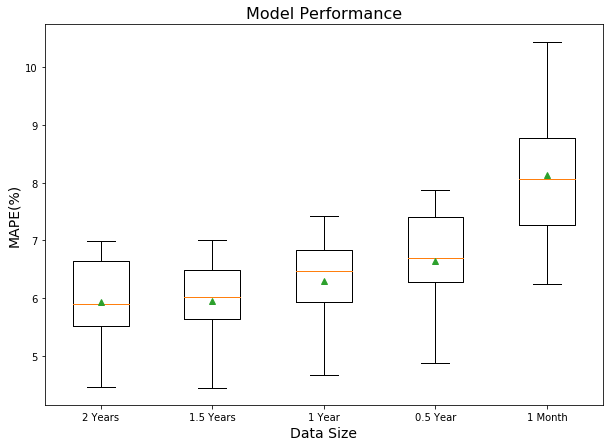

In [16]:
data_size_plot(True)

In [257]:
weather_file = pd.read_csv('darksky_data.csv')


weather_data = {}
for i in range(len(weather_file)):
    weather_data[str(weather_file.loc[i]['date_time'])[:8]]=weather_file.loc[i]['icon']

days = []
weathers = []
for day, weather in weather_data.items():
    days.append(day)
    weathers.append(weather)
    
for i, weather in enumerate(weathers):
    if weather == 'clear-night':
        weathers[i] = 'sunny'
    elif weather == 'partly-cloudy-night':
        weathers[i] = 'cloudy'
        
weather_data = {day:weather for day,weather in zip(days,weathers)}

roof_file = pd.read_csv('lower_roof.csv')
roof_id = ['28563608','28563621','28563607','28563613','28563612',
           '28563610','28563611','28563615','28563601','28563614']

roof_data = []
n = len(roof_file)
for i in range(n):
    roof_data.append(str(int(roof_file.loc[i]['date_time'])))
#     roof_data[str(int(roof_file.loc[i]['date_time']))] = []
    
roof_data = pd.DataFrame(roof_data)
for roof in roof_id:
    roof_data[roof] = roof_file[roof]
    
roof_weather = []

for i in range(n):
    day = str(int(roof_data.loc[i][0]))[:8]
    
    if day in weather_data:
        roof_weather.append(weather_data[day])
    else:
        roof_weather.append(np.float('nan'))

In [258]:
roof_data['weather'] = roof_weather
sunny = roof_data[roof_data['weather'] == 'sunny']
cloudy = roof_data[roof_data['weather'] == 'cloudy']

export_csv = roof_data.to_csv ("lowr_roof_weather.csv", index = True, header=True)

In [382]:
def mape_distribution(dataset):
    n = len(dataset)
    daily_data = {}
    
    date_col = 'date_time'
    date_col = '0'

    for i in dataset[date_col]:
        if str(i)[:8] not in daily_data:
            daily_data[str(i)[:8]] = []
            
        
    for i in dataset.index:
        day = str(dataset[date_col].loc[i])[:8]
        daily_data[day].append(dataset.loc[i])
        
        
    mape_list = {'0-10':[],'10-20':[],'20-30':[],'30-40':[],'40-50':[],'>50':[]}
    distribution = {'0-10':[],'10-20':[],'20-30':[],'30-40':[],'40-50':[],'>50':[]}
    
    for day, data in daily_data.items():
        one_day = pd.DataFrame(data).drop([date_col],axis=1)
        
        if len(one_day) < 10:
            continue
            
        mape = np.mean(daily_mape(one_day))
        
        if (mape < 10):
            
            mape_list['0-10'].append(day)
            distribution['0-10'].append(one_day)
        elif (mape > 10) and (mape < 20):
            mape_list['10-20'].append(day)
            distribution['10-20'].append(one_day)
        elif (mape > 20) and (mape < 30):
            mape_list['20-30'].append(day)
            distribution['20-30'].append(one_day)
        elif (mape > 30) and (mape < 40):
            mape_list['30-40'].append(day)
            distribution['30-40'].append(one_day)
        else:
            mape_list['>50'].append(day)
            distribution['>50'].append(one_day)
            
    return [mape_list,distribution]

## This function calculate daily MAPE for entire dataset
def mape_per_day(dataset):
    n = len(dataset)
    daily_data = {}
    
    date_col = 'date_time'
    date_col = '0'

    for i in dataset[date_col]:
        if str(i)[:8] not in daily_data:
            daily_data[str(i)[:8]] = []
            
        
    for i in dataset.index:
        day = str(dataset[date_col].loc[i])[:8]
        daily_data[day].append(dataset.loc[i])
        
        
    mape_list = []
    
    for day, data in daily_data.items():
        one_day = pd.DataFrame(data).drop([date_col],axis=1)
        
        if len(one_day) < 10:
            continue
            
        mape = np.mean(daily_mape(one_day))
                
        if mape < 100:
            mape_list.append(mape)
            
        mape_list = [np.mean(i) for i in mape_list]
        
    return mape_list

# This function filter out the data that has too large daily MAPE
# and return low MAPE data in DataFrame
def low_mape_filter(dataset):
    n = len(dataset)
    daily_data = {}
    
    date_col = 'date_time'
    date_col = '0'

    for i in dataset[date_col]:
        if str(i)[:8] not in daily_data:
            daily_data[str(i)[:8]] = []
        
    for i in dataset.index:
        day = str(dataset[date_col].loc[i])[:8]
        daily_data[day].append(dataset.loc[i])
        
    low_mape_data = []
    
    for day, data in daily_data.items():
        one_day = pd.DataFrame(data).drop([date_col],axis=1)
        
        if len(one_day) < 10:
            continue
        
        mape = daily_mape(one_day)
    
        if np.mean(mape) < 10:
            low_mape_data.append(one_day)
        
    df = pd.DataFrame()
    for i in low_mape_data:
        df = df.append(i)
        
    return df

In [383]:
lower_dataset = pd.read_csv('lowr_roof_weather.csv').drop(['Unnamed: 0','weather'],axis=1)

day_dis_lower, data_dis_lower = mape_distribution(lower_dataset)

# lower_dataset = lower_dataset[lower_dataset['weather']=='sunny']
# lower_dataset = lower_dataset.drop(['weather'],axis=1)
# lower = low_mape_filter(lower_dataset)
# lower_mape_list = mape_per_day(dataset)
# lower = daily_mape(lower)

20171015


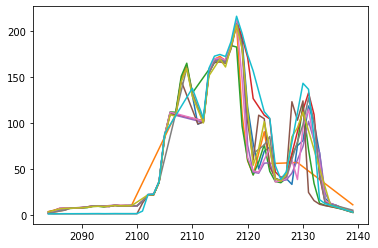

In [525]:
# histogram([int(i[4:6]) for i in day_dis_lower['>50']],True)
print(day_dis_lower['20-30'][1])
plt.plot(data_dis_lower['20-30'][1])
res,pred = daily_mape(data_dis_lower['20-30'][1])

In [526]:
data_dis_lower['20-30'][7]

,28563608,28563621,28563607,28563613,28563612,28563610,28563611,28563615,28563601,28563614
3677,0.628,0.935000,0.844,1.890000,1.122000,1.716,2.815,0.725000,0.960000,0.457000
3678,3.351,3.430000,0.905,3.415000,3.452000,3.242,3.469,3.495000,0.957000,1.326000
3679,3.718,3.803000,3.653,3.783000,3.761000,3.623,3.884,3.862500,3.634000,1.371000
3680,4.037,4.176000,3.988,4.169000,4.155000,3.976,4.205,4.230000,4.023500,1.386000
3681,4.475,4.657000,4.410,4.583000,4.566000,4.429,4.628,4.639000,4.413000,1.384000
...,...,...,...,...,...,...,...,...,...,...
3761,24.528,66.873667,31.659,23.674857,26.485000,24.875,34.482,13.292857,23.668000,16.522545
3762,28.518,74.389444,42.415,21.072714,26.067000,29.785,22.493,12.343071,37.472000,14.688818
3763,12.862,26.630333,6.347,8.062000,9.507000,6.097,11.043,7.594143,12.720571,5.520182
3764,4.180,20.902500,3.501,6.970250,4.277000,3.430,4.243,6.644357,10.988857,3.686455


In [515]:
len(data_dis_lower['10-20'][7])

58

In [506]:
# bootstrapping 
def bootstrap(dataset, sample_size):
    
    sample_size = int(len(train)*0.8)
    boot = resample(train, replace=True, n_samples=sample_size, random_state=2)
    
    return boot

# read the data
# dataset = pd.read_csv('lowr_roof_weather.csv').drop(['Unnamed: 0','weather'],axis=1)
dataset = data_dis_lower['20-30'][7]
dataset = dataset.dropna()
dataset = dataset.values

# normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

# prepare the data
train_test_ratio = 0.8
sample_size = 0.6
train_size = int(train_test_ratio*len(dataset))
train, test = dataset[:train_size], dataset[train_size:]

# bootstrapping 
train = bootstrap(train, sample_size)

# create train and test dataset
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)

model = RandomForestRegressor(n_estimators=10,max_depth=10, random_state=0).fit(trainX, trainY)
predictions = model.predict(testX)
score = mean_absolute_percentage_error(testY, predictions)

score

array([47.83121091])

In [338]:
west_dataset = pd.read_csv('west_data.csv')
east_dataset = pd.read_csv('east_data.csv')

# lower_dataset = lower_dataset[lower_dataset['weather']=='sunny']
# lower_dataset = lower_dataset.drop(['weather'],axis=1)

west = low_mape_filter(west_dataset)
east = low_mape_filter(east_dataset)
west_mape_list = mape_per_day(west_dataset)
east_mape_list = mape_per_day(east_dataset)
west = daily_mape(west)
east = daily_mape(east)

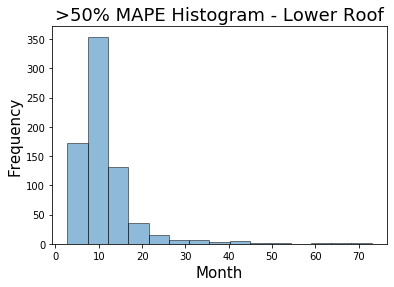

In [414]:
def histogram(data,save=False):

    counts, bins = np.histogram(data,bins=15)
    plt.hist(bins[:-1], bins, weights=counts,alpha=0.5, histtype='bar', ec='black')
    plt.title('>50% MAPE Histogram - Lower Roof',fontsize=18)
    plt.xlabel('Month',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    
    if save is True:
        plt.savefig('lower_roof_>_50_mape.jpg', format='jpg', dpi=1000, bbox_inches='tight')
    
histogram(east_mape_list,True)

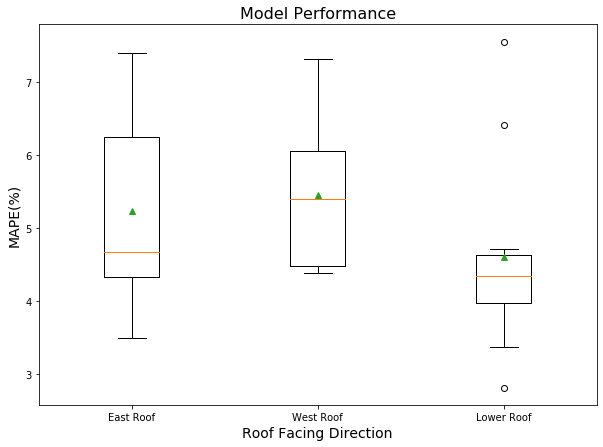

In [354]:


# make the plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
    
title_name = "Model Performance"
box = plt.boxplot([east,west,lower],patch_artist=False, showmeans=True)
    
ax.set_title(title_name,fontsize=16)
ax.xaxis.set_ticklabels(["East Roof", "West Roof","Lower Roof"])
ax.set_xlabel('Roof Facing Direction',fontsize=14)
ax.set_ylabel('MAPE(%)',fontsize=14)
    
#     if save is True:

plt.savefig('model_performance.jpg', format='jpg', dpi=1000, bbox_inches='tight')
        

In [486]:
def rf_return_prediction(X,Y):
    
    cvscores = []
    k_fold = KFold(n_splits=3, shuffle=True, random_state=0)
        
    total_predict = []
    for train_index, test_index in k_fold.split(X, Y):
        
        X_train, y_train = add_noise(X[train_index], Y[train_index])
        
        X_test = X[test_index]
        y_test = Y[test_index]        
        
        rf_model = RandomForestRegressor(n_estimators=10,max_depth=10, random_state=0).fit(X_train, y_train)
        rf_prediction = rf_model.predict(X_test)
        total_predict.extend(rf_prediction)
        score = mean_absolute_percentage_error(y_test, rf_prediction)
        cvscores.append(score)
        
    return [np.mean(cvscores),total_predict]

def daily_mape(dataset):
    
    result = []
    prediction = []
    
    for col in dataset.columns:
            
        # prepare data
        X = dataset.loc[:, dataset.columns!=col].values
        Y = dataset.loc[:, dataset.columns==col].values
        
        # normalize the data
        scaler = MinMaxScaler(feature_range=(0,1))
        X = np.array(scaler.fit_transform(X))
        Y = np.array(scaler.fit_transform(Y))
        
        res,pred = rf_return_prediction(X, Y)
        result.append(res)
        prediction.append(pred)
        
    return [result,prediction]

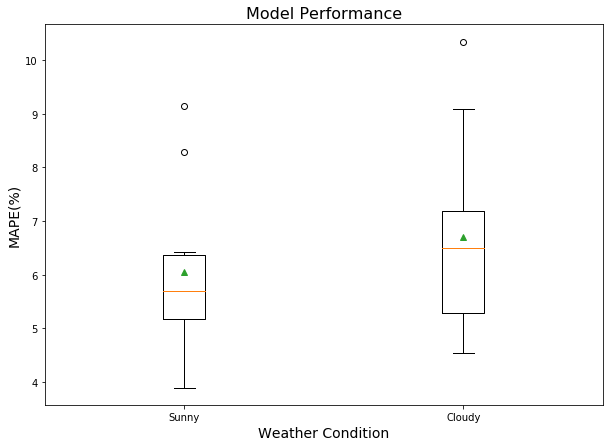

In [142]:
def weather_plot(sunny,cloudy,save=False):
    
    datasets = [sunny,cloudy]
    results = []
    
    for dataset in datasets:
        
        result = []
        
        for col in dataset.columns:
            
            # prepare data
            X = dataset.loc[:, dataset.columns!=col].values
            Y = dataset.loc[:, dataset.columns==col].values
        
            # normalize the data
            scaler = MinMaxScaler(feature_range=(0,1))
            X = np.array(scaler.fit_transform(X))
            Y = np.array(scaler.fit_transform(Y))
        
            result.append(random_forest(X, Y))
        results.append(result)
        
    # make the plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1,1,1)
    
    title_name = "Model Performance"
    box = plt.boxplot(results,patch_artist=False, showmeans=True)
    
    ax.set_title(title_name,fontsize=16)
    ax.xaxis.set_ticklabels(["Sunny", "Cloudy"])
    ax.set_xlabel('Weather Condition',fontsize=14)
    ax.set_ylabel('MAPE(%)',fontsize=14)
    
    if save is True:

        plt.savefig('weather_performance.jpg', format='jpg', dpi=1000, bbox_inches='tight')
        
    return

weather_plot(sunny_clean,cloudy_clean, True)